# Predicting bike rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. we'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [86]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


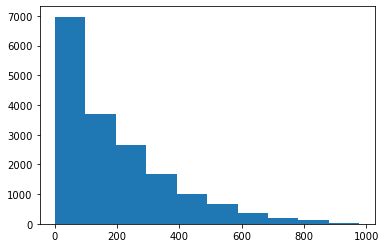

In [87]:
plt.hist(bike_rentals['cnt'])
plt.show()

In [88]:
# calculate how much each feature is correlated with the target column
bike_rentals.corr()['cnt'][:-1].sort_values(ascending=False)

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

In [89]:
def assign_label(hour):
    if hour > 6 and hour <= 12:
        return 1
    elif hour > 12 and hour <= 18:
        return 2
    elif hour > 18 and hour <= 24:
        return 3
    else:
        return 4

In [90]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,4
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


### Test/train data split

In [91]:
train = bike_rentals.sample(frac=0.8)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 16176 to 9119
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     13903 non-null  int64  
 1   dteday      13903 non-null  object 
 2   season      13903 non-null  int64  
 3   yr          13903 non-null  int64  
 4   mnth        13903 non-null  int64  
 5   hr          13903 non-null  int64  
 6   holiday     13903 non-null  int64  
 7   weekday     13903 non-null  int64  
 8   workingday  13903 non-null  int64  
 9   weathersit  13903 non-null  int64  
 10  temp        13903 non-null  float64
 11  atemp       13903 non-null  float64
 12  hum         13903 non-null  float64
 13  windspeed   13903 non-null  float64
 14  casual      13903 non-null  int64  
 15  registered  13903 non-null  int64  
 16  cnt         13903 non-null  int64  
 17  time_label  13903 non-null  int64  
dtypes: float64(4), int64(13), object(1)
memory usage: 2.0+ MB


In [92]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 0 to 17377
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     3476 non-null   int64  
 1   dteday      3476 non-null   object 
 2   season      3476 non-null   int64  
 3   yr          3476 non-null   int64  
 4   mnth        3476 non-null   int64  
 5   hr          3476 non-null   int64  
 6   holiday     3476 non-null   int64  
 7   weekday     3476 non-null   int64  
 8   workingday  3476 non-null   int64  
 9   weathersit  3476 non-null   int64  
 10  temp        3476 non-null   float64
 11  atemp       3476 non-null   float64
 12  hum         3476 non-null   float64
 13  windspeed   3476 non-null   float64
 14  casual      3476 non-null   int64  
 15  registered  3476 non-null   int64  
 16  cnt         3476 non-null   int64  
 17  time_label  3476 non-null   int64  
dtypes: float64(4), int64(13), object(1)
memory usage: 516.0+ KB


## Feature selection and Linear Regression model fitting

Now that we've done some exploration and manipulation, we're ready to apply linear regression to the data. Linear regression works fairly well on this data, given that many of the columns are highly correlated with cnt.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We'll ignore the casual and registered columns because cnt is derived from them. If we're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

In [93]:
features = bike_rentals.columns.drop(['cnt', 'dteday', 'casual', 'registered', 'instant', 
                                      'weathersit', 'holiday', 'weekday', 'workingday'])
features

Index(['season', 'yr', 'mnth', 'hr', 'temp', 'atemp', 'hum', 'windspeed',
       'time_label'],
      dtype='object')

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression()
lr.fit(train[features], train['cnt'])
preds = lr.predict(test[features])
mse = mean_squared_error(test['cnt'], preds)
mae = mean_absolute_error(test['cnt'], preds)
print('MSE: ', mse)
print('MAE: ', mae)

MSE:  16532.71992705185
MAE:  95.69601133587953


The error values seem pretty high. The Mean Absolute Error is 97, which seems relatively large.

## Fit a Decision Tree

Now we'll try to apply a decision tree algorithm instead. We'll be able to compare the decision tree algorithm error with the error from linear regression, which will enable you to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [95]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score

dt = DecisionTreeRegressor()
dt.fit(train[features], train['cnt'])
preds = dt.predict(test[features])
mse = mean_squared_error(test['cnt'], preds)
mae = mean_absolute_error(test['cnt'], preds)
print('MSE: ', mse)
print('MAE: ', mae)

MSE:  12486.363995972382
MAE:  67.27114499424626


The error went down compared to when we were using Linear Regression. 

Can we make the model better by experimenting with some parameters?

In [96]:
dt = DecisionTreeRegressor(min_samples_leaf=10)
dt.fit(train[features], train['cnt'])
preds = dt.predict(test[features])
mse = mean_squared_error(test['cnt'], preds)
mae = mean_absolute_error(test['cnt'], preds)
print('MSE: ', mse)
print('MAE: ', mae)

MSE:  8781.488372357882
MAE:  60.49286200047757


Now we'll apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [97]:
from sklearn.ensemble import RandomForestRegressor

fr = RandomForestRegressor()
fr.fit(train[features], train['cnt'])
preds = fr.predict(test[features])
train_preds = fr.predict(train[features])
mse = mean_squared_error(test['cnt'], preds)
mse_train = mean_squared_error(train['cnt'], train_preds)
mae = mean_absolute_error(test['cnt'], preds)
mae_train = mean_absolute_error(train['cnt'], train_preds)
print('MSE: ', mse)
print('MSE train: ', mse_train)
print('MAE: ', mae)
print('MAE train: ', mae_train)

MSE:  7581.948154462206
MSE train:  1086.219499356858
MAE:  55.86953545773367
MAE train:  20.866607843366204


This model further improved the error compared to a single Decision Tree. Let's try playing with some parameters to see if we can improve it further:

In [98]:
fr = RandomForestRegressor(min_samples_leaf=2)
fr.fit(train[features], train['cnt'])
preds = fr.predict(test[features])
train_preds = fr.predict(train[features])
mse = mean_squared_error(test['cnt'], preds)
mse_train = mean_squared_error(train['cnt'], train_preds)
mae = mean_absolute_error(test['cnt'], preds)
mae_train = mean_absolute_error(train['cnt'], train_preds)
print('MSE: ', mse)
print('MSE train: ', mse_train)
print('MAE: ', mae)
print('MAE train: ', mae_train)

MSE:  7434.302393139538
MSE train:  2136.5922491733613
MAE:  55.86040072531356
MAE train:  29.394162813807945


In [99]:
fr = RandomForestRegressor(max_features=6)
fr.fit(train[features], train['cnt'])
preds = fr.predict(test[features])
train_preds = fr.predict(train[features])
mse = mean_squared_error(test['cnt'], preds)
mse_train = mean_squared_error(train['cnt'], train_preds)
mae = mean_absolute_error(test['cnt'], preds)
mae_train = mean_absolute_error(train['cnt'], train_preds)
print('MSE: ', mse)
print('MSE train: ', mse_train)
print('MAE: ', mae)
print('MAE train: ', mae_train)

MSE:  7430.458680680369
MSE train:  1075.3851258545317
MAE:  55.61239148377993
MAE train:  20.83269277813741


## Conclusions

We managed to cut the error of our model to almost half, starting from a simple Linear Regressor and ending up with a Random Forest Regressor.